In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"

using UMAP, Muon
using Distances
using SPI
using DataFrames, CSV
using StatsBase
using StatsPlots
theme(:default, grid=false, framestyle=:box, label="", ratio=1)

In [2]:
ddir = datadir("exp_pro", "BB669")
rdir = projectdir("_research", "UMAPof669isolates") |> mkpath
pdir = plotsdir("UMAPof669isolates") |> mkpath
biobank = readh5mu(joinpath(ddir, "BB669.h5mu"))

┌ Warning: Cannot join columns with the same name because var_names are intersecting.
└ @ Muon /Users/ben/.julia/packages/Muon/eLqpV/src/mudata.jl:351


MuData object 669 ✕ 21473
└ metabolites_foldchange
  AnnData object 669 ✕ 38
└ metabolites_millimolar
  AnnData object 669 ✕ 10
└ UPorder_oggs
  AnnData object 669 ✕ 10177
└ oggs
  AnnData object 669 ✕ 11248

In [3]:
mtx = biobank["UPorder_oggs"].X[:,:];

In [4]:
bbusv = SVD(
    biobank["UPorder_oggs"].obsm["inferredLSVs"][:,:],
    biobank["UPorder_oggs"].uns["UP_SVs"][:],
    biobank["UPorder_oggs"].varm["UP_RSVs"][:, :]',
    );
norm(mtx .- projectout(bbusv)) / norm(mtx)

0.03022666734934216

In [19]:
donorid = biobank.obs.donor
familyid = biobank.obs.family_ncbi
replace!(familyid, "<unclassified>" => "<unknown family>");

In [20]:
sort(countmap(familyid), byvalue=true, rev=true)

OrderedCollections.OrderedDict{String, Int64} with 12 entries:
  "Lachnospiraceae"              => 347
  "Bacteroidaceae"               => 229
  "Bifidobacteriaceae"           => 30
  "Tannerellaceae"               => 21
  "Prevotellaceae"               => 14
  "Rikenellaceae"                => 9
  "Erysipelotrichaceae"          => 5
  "Oscillospiraceae"             => 4
  "<unknown family>"             => 4
  "Odoribacteraceae"             => 4
  "Enterobacteriaceae"           => 1
  "Eubacteriales incertae sedis" => 1

In [21]:
csb_mtx = biobank["oggs"].X[:,:]
bbusv_csb = svd(csb_mtx);

In [22]:
pctvar = SPI.explainedvariance(bbusv_csb.S) .* 100

669-element Vector{Float64}:
 68.5743263555367
 16.1444936352833
  1.6177318590582606
  1.40438723023781
  1.2059400001284448
  0.84794726438795
  0.7602421579353775
  0.7002405381427096
  0.6578864258463004
  0.6102826214803216
  ⋮
  5.468870496580919e-31
  5.468870496580919e-31
  5.468870496580919e-31
  5.468870496580919e-31
  5.468870496580919e-31
  5.468870496580919e-31
  5.468870496580919e-31
  5.468870496580919e-31
  5.705493448923059e-32

In [23]:
sum(pctvar[1:2])

84.71881999082

In [24]:
sum(pctvar[1:10])

92.5234780880372

In [25]:
# specieslabels = [
#     "Bacteroides uniformis",
#     "Phocaeicola vulgatus",
#     "Bacteroides thetaiotaomicron",
#     "[Ruminococcus] gnavus",
#     "Bifidobacterium breve",
#     "[Eubacterium] rectale",
#     "Dorea formicigenerans",
#     "Coprococcus comes",
#     "Blautia luti & Blautia wexlerae",
#     "Anaerostipes hadrus",
# ]
# shapes = permutedims([:circle, :rect, :star5, :diamond, :hexagon, :ltriangle, :pentagon, :utriangle, :dtriangle, :rtriangle, :star4])
# speciescolors = wload(joinpath(ddir, "subsettreecolors.jld2"))["colors"]
# speciescolors_ordered = permutedims(speciescolors[replace(indexin(sort(unique(bbobs_trn.species)), specieslabels), nothing=>9)])

In [27]:
orderedfamilylabels = stack(DataFrame(countmap(familyid)), 1:12) |>
    df -> DataFrames.transform(df, :value => (-) => :minusvalue) |>
    df -> sort(df, [:minusvalue, :variable], rev=false) |>
    df -> df.variable
familycolors = permutedims(palette(:Set3_12).colors.colors[indexin(sort(unique(familyid)), orderedfamilylabels)])

## Original matrix

In [28]:
orig_coords = umap(float.(csb_mtx)', 2; n_neighbors=size(csb_mtx, 1)-1, metric=Euclidean())';

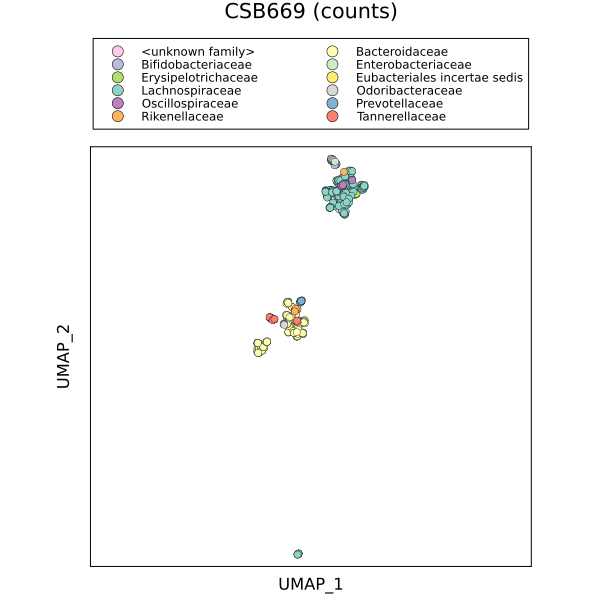

In [29]:
scatter(orig_coords[:, 1], orig_coords[:, 2],
    group=familyid,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=2,
    c=familycolors,
    ticks=:none,
    title="CSB669 (counts)",
    xlabel="UMAP_1",
    ylabel="UMAP_2",
)

In [30]:
savefig(joinpath(pdir, "umap_counts_669isolates_byfamily.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates/umap_counts_669isolates_byfamily.pdf"

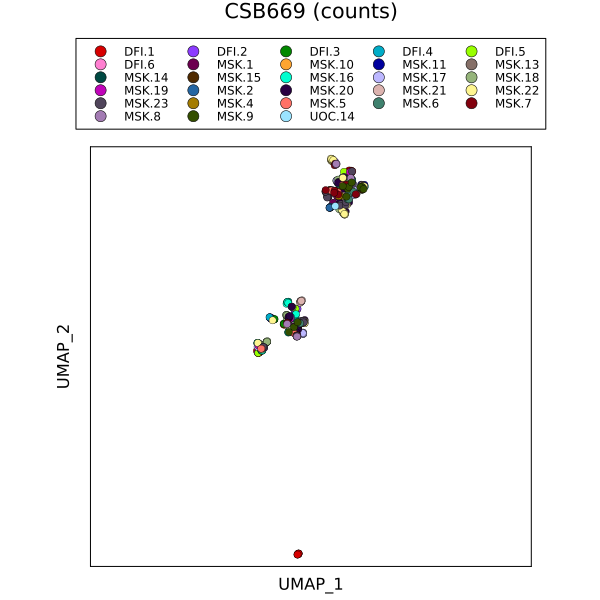

In [31]:
scatter(orig_coords[:, 1], orig_coords[:, 2],
    group=donorid,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=5,
    c=permutedims(palette(:glasbey_bw_n256).colors.colors),
    ticks=:none,
    title="CSB669 (counts)",
    xlabel="UMAP_1",
    ylabel="UMAP_2",
)

In [32]:
savefig(joinpath(pdir, "umap_counts_669isolates_bydonor.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates/umap_counts_669isolates_bydonor.pdf"

## Top PCs

In [33]:
pcs_csb = bbusv_csb.U * diagm(bbusv_csb.S)
pcs_coords = umap(pcs_csb[:, 1:10]', 2; n_neighbors=355, metric=Euclidean())';

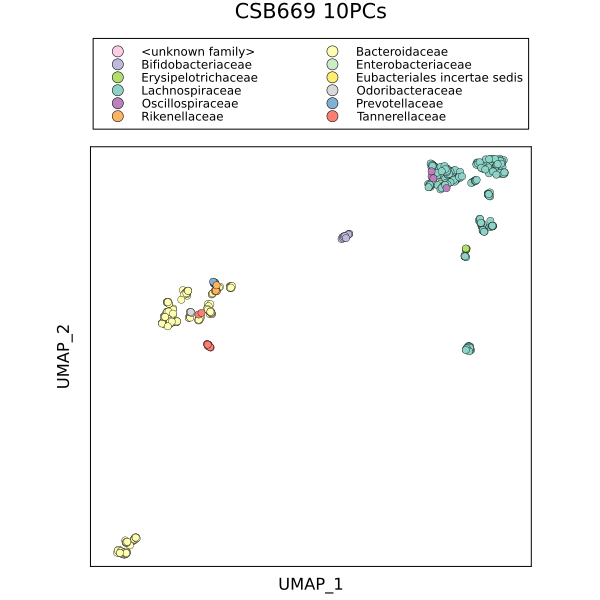

In [34]:
scatter(pcs_coords[:, 1], pcs_coords[:, 2],
    group=familyid,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=2,
    c=familycolors,
    ticks=:none,
    title="CSB669 10PCs",
    xlabel="UMAP_1",
    ylabel="UMAP_2",
)

In [35]:
savefig(joinpath(pdir, "umap_top10PCs_669isolates_byfamily.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates/umap_top10PCs_669isolates_byfamily.pdf"

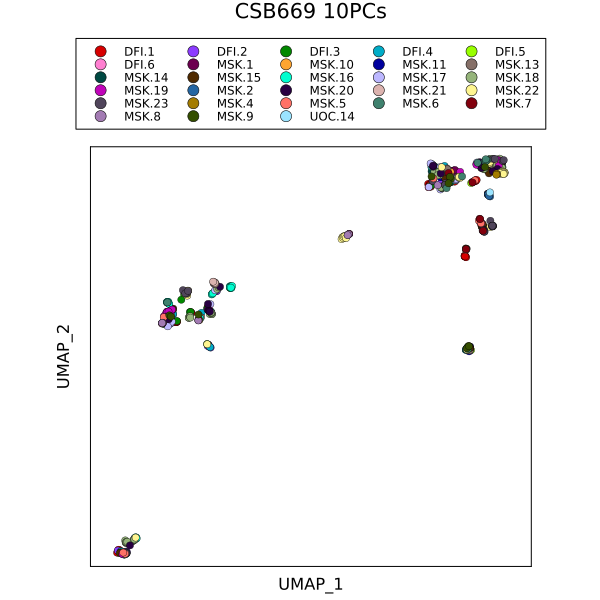

In [36]:
scatter(pcs_coords[:, 1], pcs_coords[:, 2],
    group=donorid,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=5,
    c=permutedims(palette(:glasbey_bw_n256).colors.colors),
    ticks=:none,
    title="CSB669 10PCs",
    xlabel="UMAP_1",
    ylabel="UMAP_2",
)

In [37]:
savefig(joinpath(pdir, "umap_top10PCs_669isolates_bydonor.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates/umap_top10PCs_669isolates_bydonor.pdf"

## PC plots

In [38]:
pctvar = SPI.explainedvariance(bbusv_csb.S) .* 100;

In [39]:
pcs_csb = bbusv_csb.U * diagm(bbusv_csb.S)
# pcs_coords = umap(pcs_csb[:, 1:10]', 2; n_neighbors=355, metric=Euclidean())';

669×669 Matrix{Float64}:
 -112.801   -27.3099    6.49124   -3.15766   …   0.0           0.0
 -159.456   -46.9128    3.53239   -1.87018      -2.83621e-30  -1.19885e-28
 -156.299   -42.0726    1.4705    -1.16948      -4.23139e-30   3.5182e-28
 -153.112   -43.5201   12.164    -18.3103        1.18624e-17   1.15374e-14
 -168.229   -47.8656   -5.39674   10.4025       -1.55917e-29   4.29862e-28
 -167.986   -47.5712   -5.44556   10.4161    …  -1.739e-28     6.00717e-28
 -216.735   -63.5251  -21.9006    27.6561       -7.32013e-29  -6.27578e-29
 -164.946   -48.1611   12.2325   -19.6862        5.939e-30    -4.43619e-29
 -228.609   -74.9903  -24.0148    32.894        -1.64768e-29  -1.44628e-27
 -155.459   -45.0148   15.0988   -22.88         -8.60863e-30  -1.13927e-28
    ⋮                                        ⋱                
 -142.905   -47.3843   13.6441     1.95936   …  -6.01868e-30  -3.25592e-30
 -144.232   -47.0175   13.7384     1.68935      -2.85479e-32  -2.60473e-30
 -224.707   -74.3895 

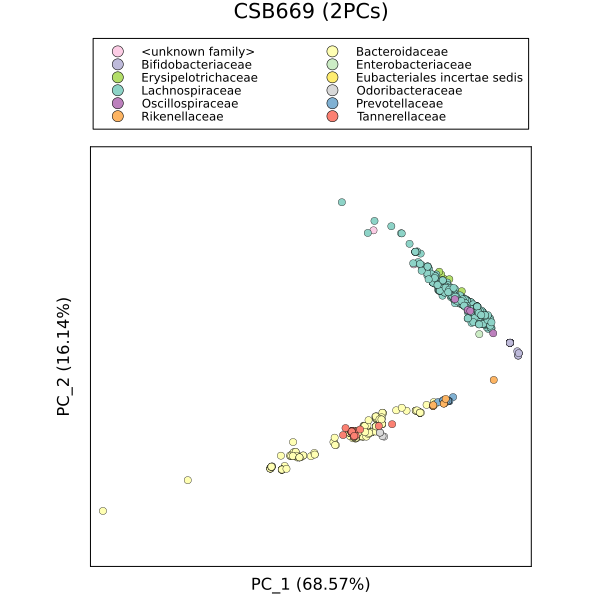

In [40]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    group=familyid,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=2,
    c=familycolors,
    ticks=:none,
    title="CSB669 (2PCs)",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [41]:
savefig(joinpath(pdir, "PCplot_PCs1and2_669isolates_byfamily.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates/PCplot_PCs1and2_669isolates_byfamily.pdf"

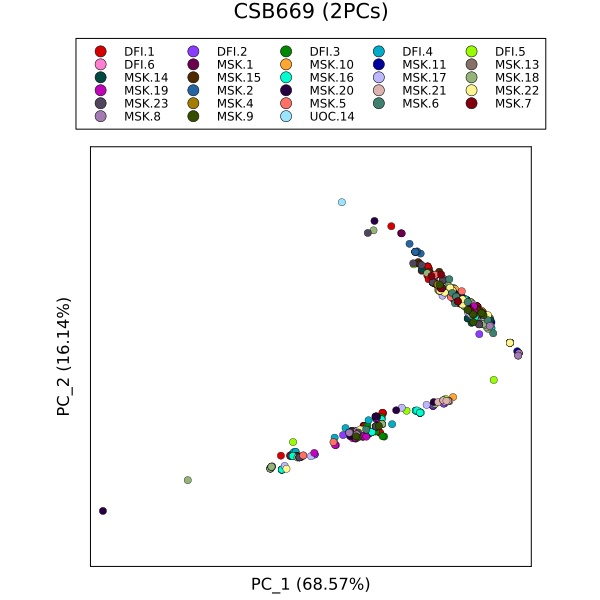

In [42]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    group=donorid,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=5,
    c=permutedims(palette(:glasbey_bw_n256).colors.colors),
    ticks=:none,
    title="CSB669 (2PCs)",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [43]:
savefig(joinpath(pdir, "PCplot_PCs1and2_669isolates_bydonor.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates/PCplot_PCs1and2_669isolates_bydonor.pdf"

## SPI distance

In [44]:
SDij = biobank["UPorder_oggs"].obsp["SDij"][:,:]
spi_coords = umap(SDij, 2; n_neighbors=355, metric=:precomputed)';

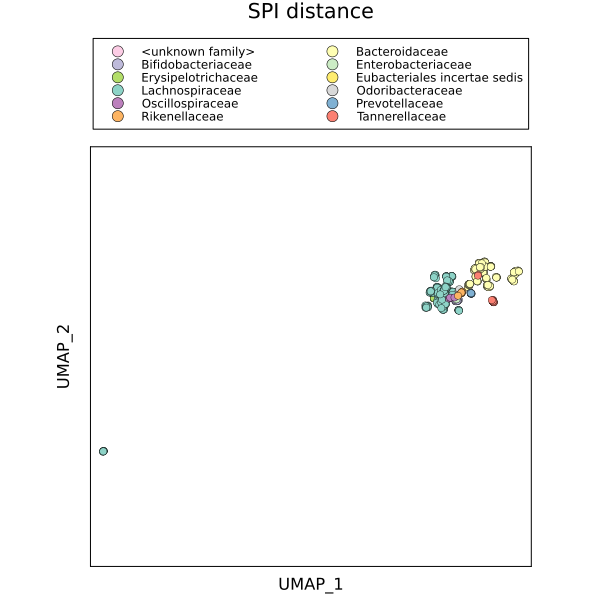

In [45]:
scatter(spi_coords[:, 1], spi_coords[:, 2],
    group=familyid,
    alpha=1, markerstrokewidth=.3,
    # markersize=3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=2,
    c=familycolors,
    ticks=:none,
    title="SPI distance",
    xlabel="UMAP_1",
    ylabel="UMAP_2",
)

In [46]:
savefig(joinpath(pdir, "umap_spidistance_669isolates_byfamily.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates/umap_spidistance_669isolates_byfamily.pdf"

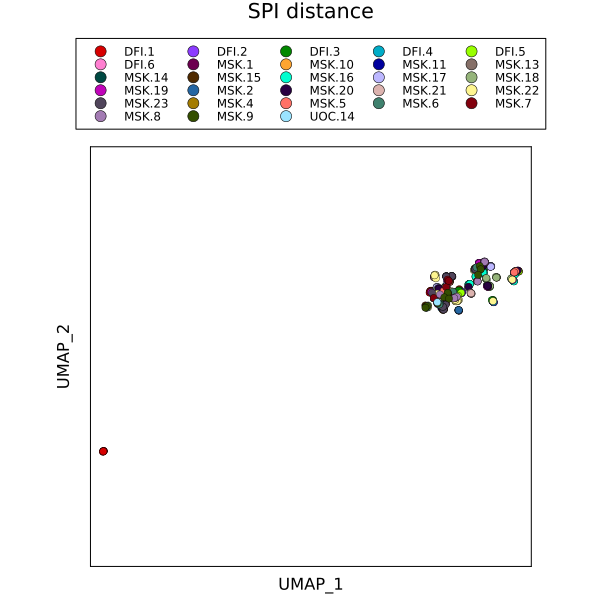

In [47]:
scatter(spi_coords[:, 1], spi_coords[:, 2],
    group=donorid,
    alpha=1, markerstrokewidth=.3,
    # markersize=2,
    size=(600,600),
    legend=:outertop,
    legendcolumns=5,
    c=permutedims(palette(:glasbey_bw_n256).colors.colors),
    ticks=:none,
    title="SPI distance",
    xlabel="UMAP_1",
    ylabel="UMAP_2",
)

In [48]:
savefig(joinpath(pdir, "umap_spidistance_669isolates_bydonor.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates/umap_spidistance_669isolates_bydonor.pdf"